# Example showing how to compute the offset calibration using the cross-talk effect in LinoSPAD2.

TODO WRITE TEXT
Import functions and set absolute path to .dat files


In [4]:
import matplotlib.pyplot as plt
from daplis.functions import cross_talk, fits
path = r"C:\Users\Ondra\Desktop\dezertacka\data\offset_w_LED"

Now, calculate timestamp differences for the pixels of interest. The result is saved in the 'cross_talk_data' folder at the same location where '.dat' data files are located.

In [ ]:
#Dont forget to set every parameter correctly here based on your data!
cross_talk.cross_talk_offset_collect(
    path,
    rewrite=True,
    daughterboard_number="B7d",
    motherboard_number="#28",
    firmware_version="2212s",
    timestamps=100,
)



> > > Collecting cross-talk data < < <

Creating pixel pairs from 0 to 255


Calculating timestamp differences between all pixels

! ! ! Feather file with timestamps differences already exists and will be rewritten ! ! !


! ! ! Deleting the file in 5 ! ! !


! ! ! Deleting the file in 4 ! ! !


! ! ! Deleting the file in 3 ! ! !


! ! ! Deleting the file in 2 ! ! !


! ! ! Deleting the file in 1 ! ! !




> > > Timestamp differences are saved as0000072934-0000073033_pixels_130-131.feather in C:\Users\Ondra\Desktop\dezertacka\data\offset_w_LED\cross_talk_data < < <


After collecting the timestamp differences, we can plot the CT peaks and offset them to zero and visualise them.

In [ ]:
#TODO  starting from pixel 131, several pixels have 0 timestamps, so they would poduce errors, inside cross_talk_offset_plot for these empty pixels mu, sig = 0, 1
correct_pix_address = False
print("Creating pixel pairs from 0 to 255")
pix_pairs = [[i, i+1] for i in range(255)]
if correct_pix_address:
    for pi, pixels in enumerate(pix_pairs):
        for i, pixel in enumerate(pixels):
            if pixel > 127:
                pixels[i] = 255 - pixel
            else:
                pixels[i] = pixel + 128
        pix_pairs[pi] = pixels
# Collecting sensor population
mus = []
multiplier = 10
for pixels in pix_pairs:
    #This explicitly sets all dead pixels to 0 mu
    mu, sigma = cross_talk.cross_talk_offset_plot(
    path,
    pixels,
    show_plot=False, multiplier = multiplier
    )
    mus.append(mu)


Creating pixel pairs from 0 to 255


[-4288.205031854736, 7779.312148296361, -4544.667644962319, 3597.2388068616356, 828.299624837905, -5076.936869493452, 2770.848182218013, 1886.783723156512, -4269.47322397363, 6134.479588114544, -2243.1972149751136, -4247.800885635266, 3393.3884272529617, 3031.3383723101174, -2920.1254307453046, 2726.1088098608343, -1825.4733329764285, -4828.976391195856, 4727.203406922582, -6157.183513957702, 4093.2555329150828, -4578.004717271949, 10333.931085806385, -4626.245647453502, 4723.094776003283, -8575.85688059376, 3116.146567116438, -1019.2483326229593, -1832.0809636110794, -1375.9465047277315, 1249.2296702321253, 204.3098307244125, -519.5814436326192, 1347.9549213292914, 1660.4221547935647, -1115.595516133088, 2765.255386731783, -3550.2266421947807, -127.22037445313264, -2089.6386844897334, 5390.817440417364, -3074.5273165703647, 765.8253825081099, -1893.9235695970838, 1425.3081260848999, 496.02325982619567, 803.2425675894852, -3030.5985202077363, 2198.490294728605, 918.6888352664755, -3198

ValueError: zero-size array to reduction operation minimum which has no identity

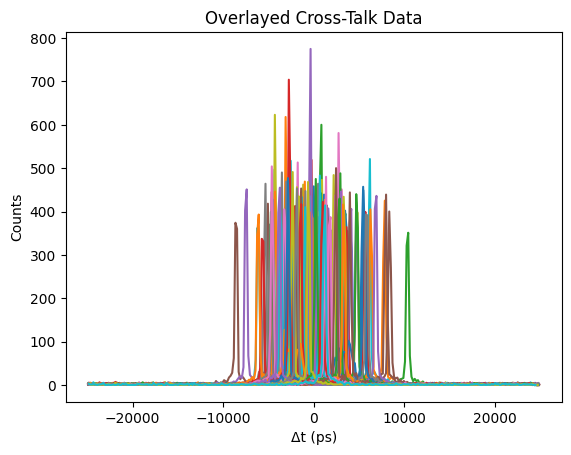

In [ ]:
# print([float(mu) for mu in mus])
# for pixels in pix_pairs:

#     cross_talk.plot_overlayed_data(path, pixels,show_plot=False, multiplier = multiplier)
# plt.show()
# for idx, pixels in enumerate(pix_pairs):

#     cross_talk.plot_normalized_data(path, pixels, mus[idx], multiplier = multiplier)
# plt.show()



# Solving the Offset Equations using a Linear Matrix Equation

## Formulation of the System

We have the system of equations:

```math
(t_i + d_i) - (t_j + d_j) = d_i - d_j = 	off_{ij}, \quad i \in [0,254]. \quad j \in [1,255].
```
Here the t_i, t_j are timestamps, which for CT are the same as delta_t = 0. The equations simplify to known offset being equal to difference between the delays in propagation.

```math
\sum_{k=0}^{255} d_k = 0.
```

Rewriting this in matrix form:

```math
Ax = b
```

where:
- \( A \) is a bidiagonal matrix,
- \( x \) represents the unknown delays values,
- \( b \) is the vector of given offsets.

## Bidiagonal Matrix Structure

The system can be represented in matrix form as:
\begin{equation}
A = 
\begin{bmatrix}
1 & -1 & 0 & 0 & \cdots & 0 \\
0 & 1 & -1 & 0 & \cdots & 0 \\
0 & 0 & 1 & -1 & \cdots & 0 \\
\vdots & \vdots & \vdots & \vdots & \ddots & \vdots \\
0 & 0 & 0 & 0 & \cdots & -1 \\
1 & 1 & 1 & 1 & \cdots & 1
\end{bmatrix}
\end{equation}

```


In [26]:
import numpy as np
import copy
from scipy.optimize import lsq_linear

offsets = copy.copy(mus)

#append 0 to mus which will be for the sum = 0
offsets.append(0)
A0 = np.eye(len(offsets))
A1 = -1*np.eye(len(offsets),k=1)
A = A0 + A1

res = lsq_linear(A, offsets)
# print(res.x, res.cost)
ppd = res.x #per pixel delay
appd = np.abs(ppd) #absolute per pixel delay as the sign is just the position fo the peak relative to origin
